In [1]:
from pathlib import Path
from python.optimization import TopOpt
from python.postprocessor import Post2D, Post3D

ANSYS_path = Path("C:/Program Files/ANSYS Inc/v202/ansys/bin/winx64/MAPDL.exe")
script_dir = Path("python/")
res_dir    = Path("results/")
mod_dir    = Path("models/")
TopOpt.set_paths(ANSYS_path, script_dir, res_dir, mod_dir)

# Test case
- Half MBB 168 mm x 80 mm x 8 mm
- Mesh:
    - **2D**: 42 x 20 elements (4 mm element)
    - **3D**: 42 x 20 x 2 elements (4 mm element)
- 1 kN downward force


- Cellulose and 0.5 bamboo
- volfrac = 0.3
- r_rho = 8
- r_theta = 20
- theta0 = 50°
- 150 iterations

In [2]:
# fiber: bamboo
rhofiber  = 700e-12 # t/mm^3
Efiber    = 17.5e3 # MPa
vfiber    = 0.04
CO2fiber  = 1.0565 # kgCO2/kg

# matrix: cellulose
rhomatrix = 990e-12 # t/mm^3
Ematrix   = 3.25e3
vmatrix   = 0.355 # MPa
CO2matrix = 3.8 # kgCO2/kg

Vfiber  = 0.5
Vmatrix = 1-Vfiber

Gfiber  = Efiber/(2*(1+vfiber))
Gmatrix = Ematrix/(2*(1+vmatrix))

Ex   = Efiber*Vfiber + Ematrix*Vmatrix
Ey   = Efiber*Ematrix / (Efiber*Vmatrix + Ematrix*Vfiber)
Gxy  = Gfiber*Gmatrix / (Gfiber*Vmatrix + Gmatrix*Vfiber)
nuxy = vfiber*Vfiber + vmatrix*Vmatrix
rho  = rhofiber*Vfiber + rhomatrix*Vmatrix

CO2mat = (rhofiber*Vfiber*CO2fiber + rhomatrix*Vmatrix*CO2matrix)/rho # kgCO2/kg
CO2veh = 1030 * 25 * 3.83 # kg_fuel/kg_transported/year * years * kgCO2/kg_fuel = kgCO2/kg

In [3]:
solver1 = TopOpt(inputfile='mbb2d', dim='2D', jobname='2d',
                Ex=Ex, Ey=Ey, nuxy=nuxy, nuyz=vmatrix, Gxy=Gxy, volfrac=0.3, r_rho=8, r_theta=20, theta0=50, max_iter=150)
solver1.optim()

print()
print('Total elapsed time     {:7.2f}s'.format(solver1.time))
print('FEA time               {:7.2f}s'.format(solver1.fea_time))
print('Derivation time        {:7.2f}s'.format(solver1.deriv_time))
print('Variable updating time {:7.2f}s'.format(solver1.mma.update_time))

Iteration   0...  compliance = 43829.0890
Iteration   1...  compliance = 12526.3284
Iteration   2...  compliance =  8667.6762
Iteration   3...  compliance =  6175.9762
Iteration   4...  compliance =  5609.1694
Iteration   5...  compliance =  5050.3935
Iteration   6...  compliance =  4556.0583
Iteration   7...  compliance =  4521.7778
Iteration   8...  compliance =  4353.3922
Iteration   9...  compliance =  4428.8614
Iteration  10...  compliance =  4472.3838
Iteration  11...  compliance =  4448.3749
Iteration  12...  compliance =  4510.0688
Iteration  13...  compliance =  4370.9995
Iteration  14...  compliance =  4378.1962
Iteration  15...  compliance =  4292.7147
Iteration  16...  compliance =  4227.5703
Iteration  17...  compliance =  4232.2764
Iteration  18...  compliance =  4191.0196
Iteration  19...  compliance =  4133.5988
Iteration  20...  compliance =  4127.4296
Iteration  21...  compliance =  3963.3583
Iteration  22...  compliance =  4041.1306
Iteration  23...  compliance =  38

CO2 footprint: 2684.50 kgCO2


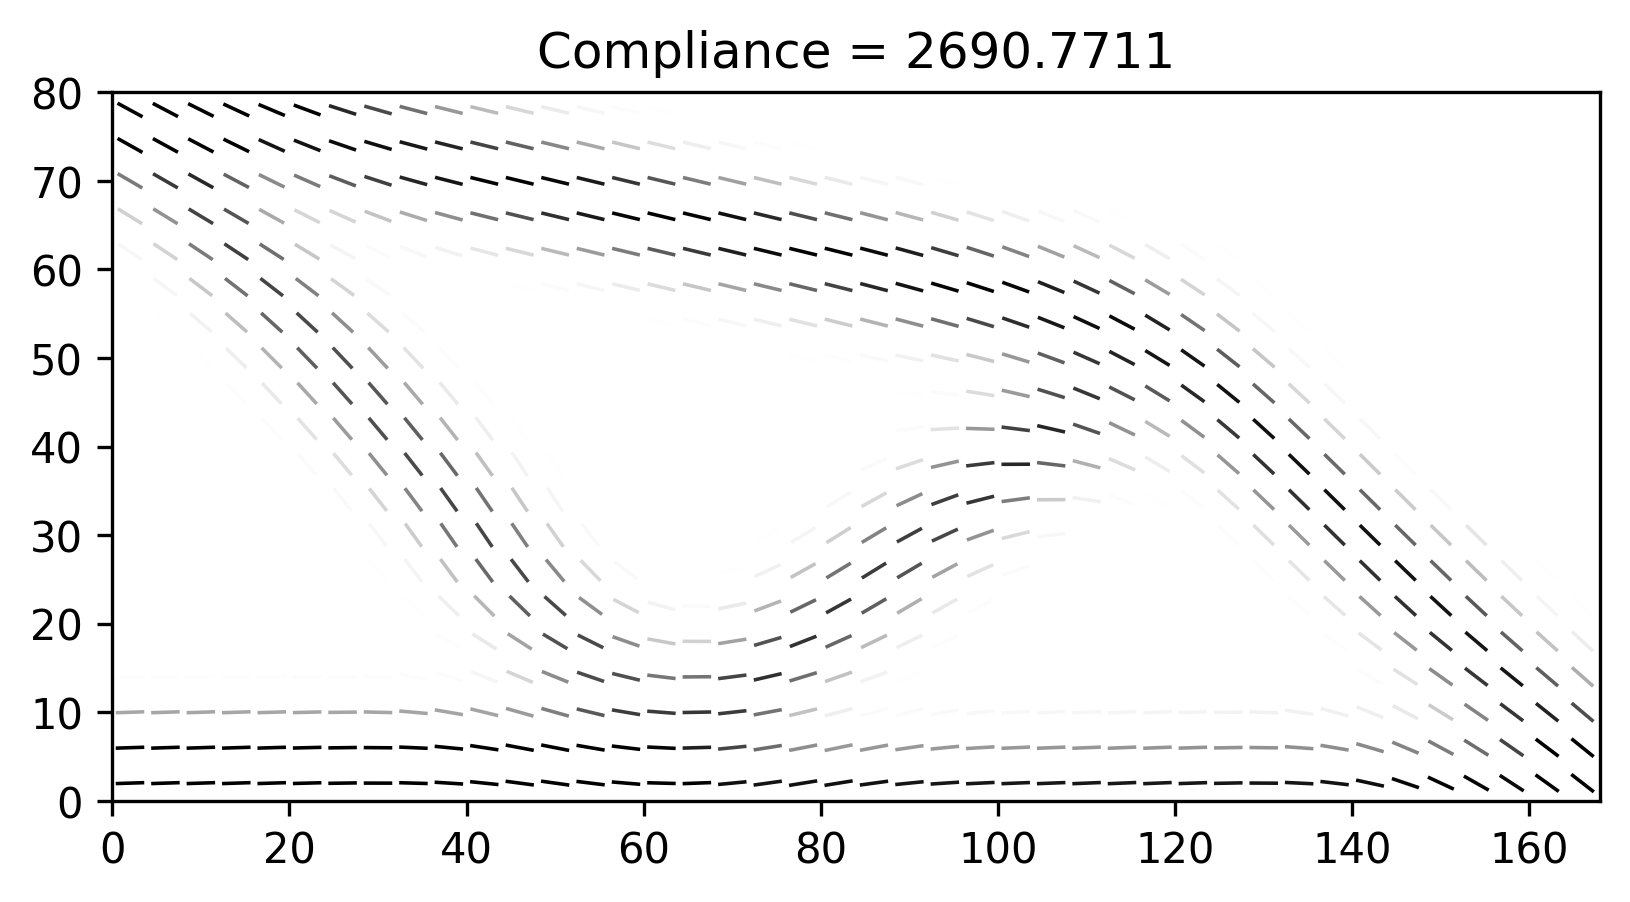

In [4]:
post1 = Post2D(solver1)
post1.plot()
print('CO2 footprint: {:.2f} kgCO2'.format(1000 * solver1.CO2_footprint(rho, CO2mat, CO2veh)))

In [5]:
solver2 = TopOpt(inputfile='mbb3d', dim='3D_layer', jobname='3d',
                Ex=Ex, Ey=Ey, nuxy=nuxy, nuyz=vmatrix, Gxy=Gxy, volfrac=0.3, r_rho=8, r_theta=20, theta0=50, max_iter=150)
solver2.optim()

print()
print('Total elapsed time:     {:7.2f}s'.format(solver2.time))
print('FEA time:               {:7.2f}s'.format(solver2.fea_time))
print('Derivation time:        {:7.2f}s'.format(solver2.deriv_time))
print('Variable updating time: {:7.2f}s'.format(solver2.mma.update_time))

Iteration   0...  compliance = 44636.4407
Iteration   1...  compliance = 12802.0051
Iteration   2...  compliance =  8619.5963
Iteration   3...  compliance =  6068.7018
Iteration   4...  compliance =  5704.7559
Iteration   5...  compliance =  4588.6923
Iteration   6...  compliance =  4820.2946
Iteration   7...  compliance =  4407.7716
Iteration   8...  compliance =  4637.5125
Iteration   9...  compliance =  4439.0622
Iteration  10...  compliance =  4495.3520
Iteration  11...  compliance =  4539.9972
Iteration  12...  compliance =  4494.2074
Iteration  13...  compliance =  4525.9791
Iteration  14...  compliance =  4382.2912
Iteration  15...  compliance =  4312.7989
Iteration  16...  compliance =  4265.5597
Iteration  17...  compliance =  4237.6846
Iteration  18...  compliance =  4198.9555
Iteration  19...  compliance =  4105.4645
Iteration  20...  compliance =  4102.7981
Iteration  21...  compliance =  3989.7926
Iteration  22...  compliance =  3902.0239
Iteration  23...  compliance =  39

CO2 footprint: 2586.36 kgCO2


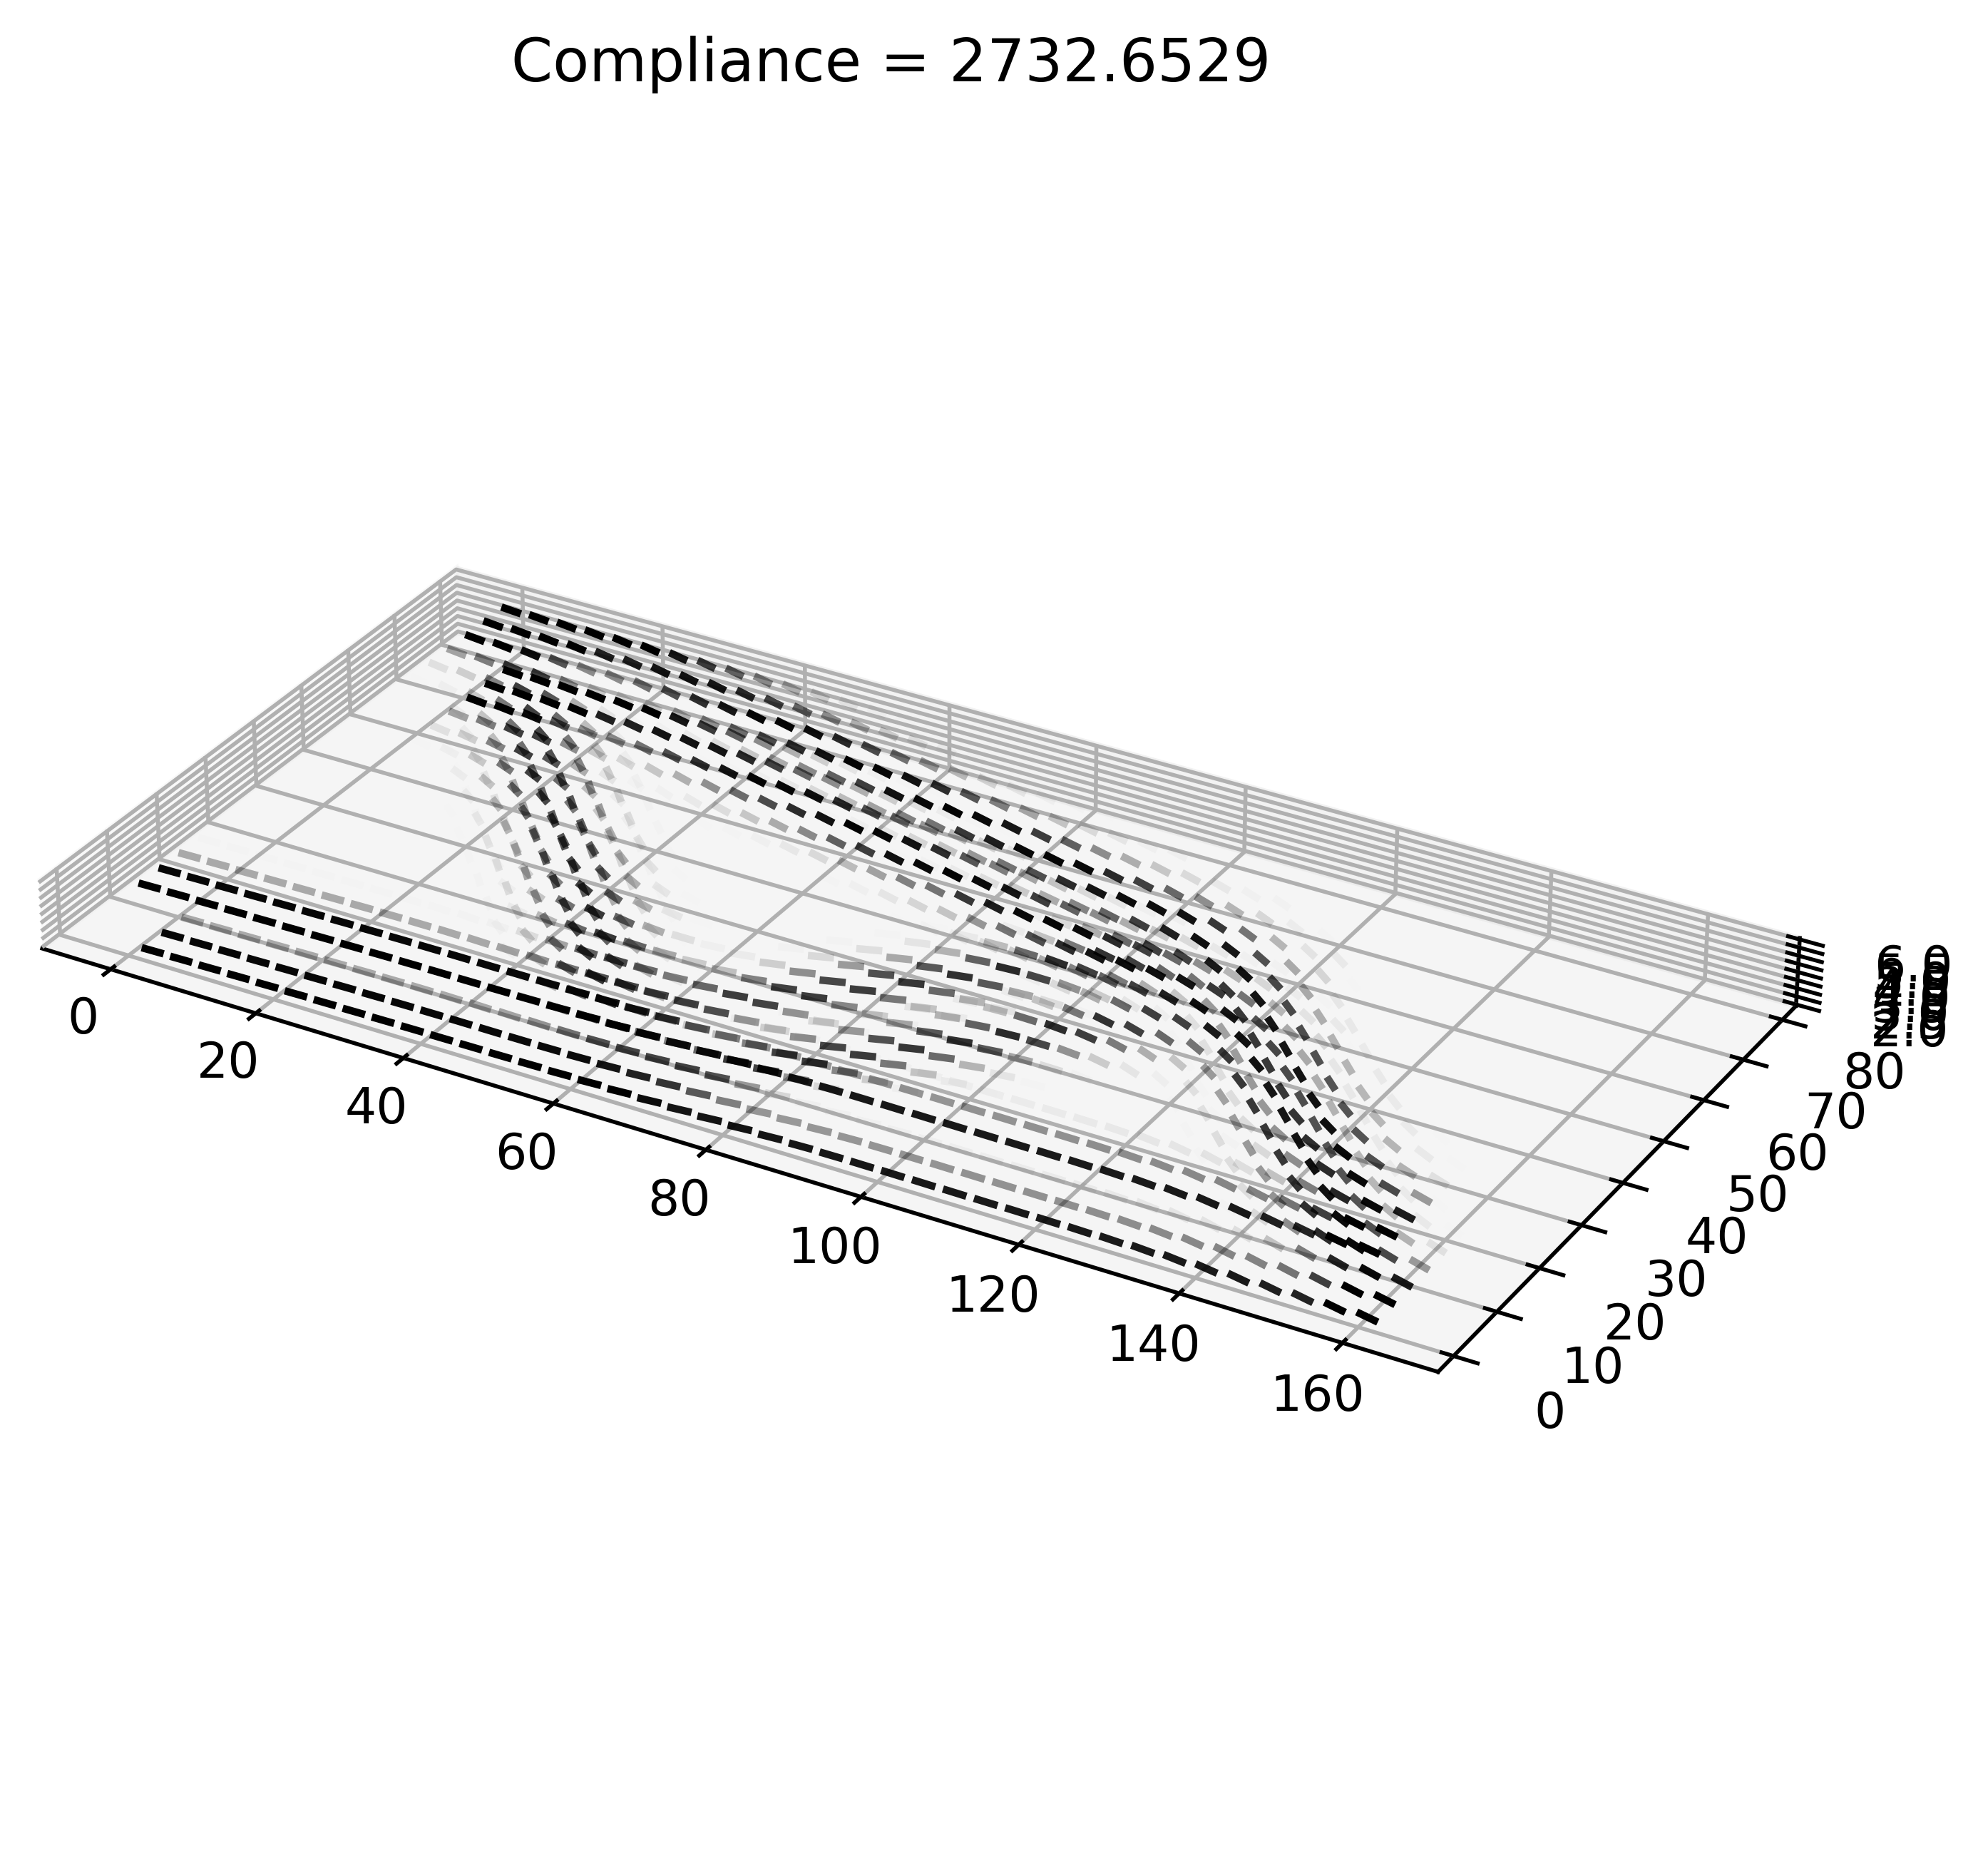

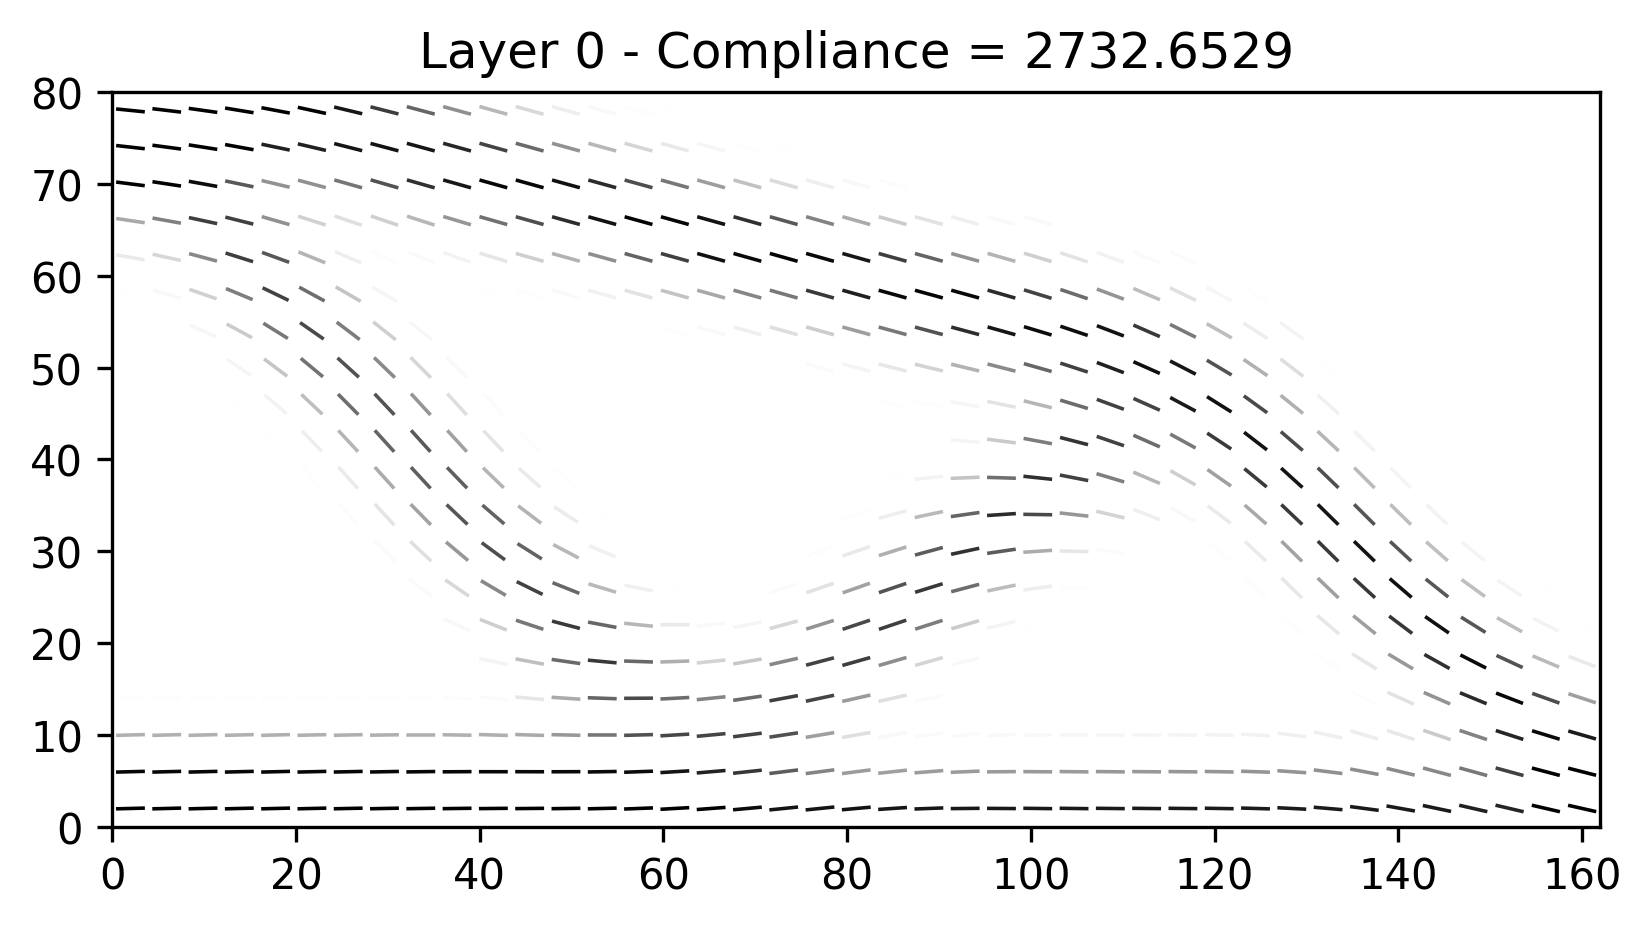

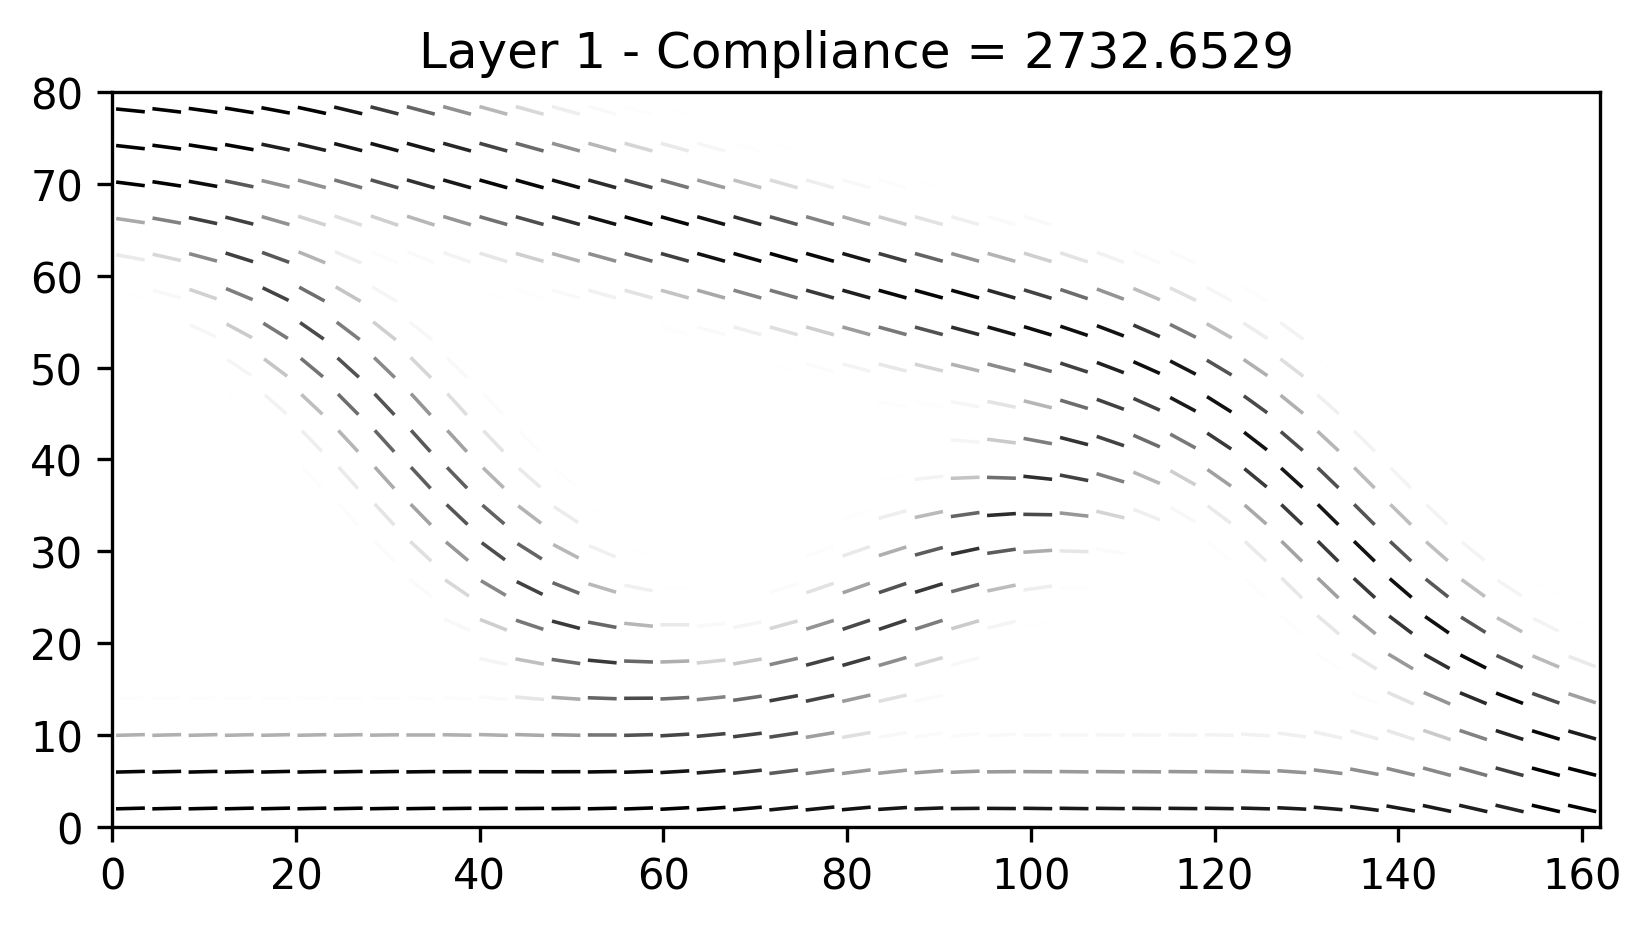

In [6]:
post2 = Post3D(solver2)
post2.plot(colorful=False)
post2.plot_layer(layer=0)
post2.plot_layer(layer=1)

print('CO2 footprint: {:.2f} kgCO2'.format(1000 * solver2.CO2_footprint(rho, CO2mat, CO2veh)))

findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: 

findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: 

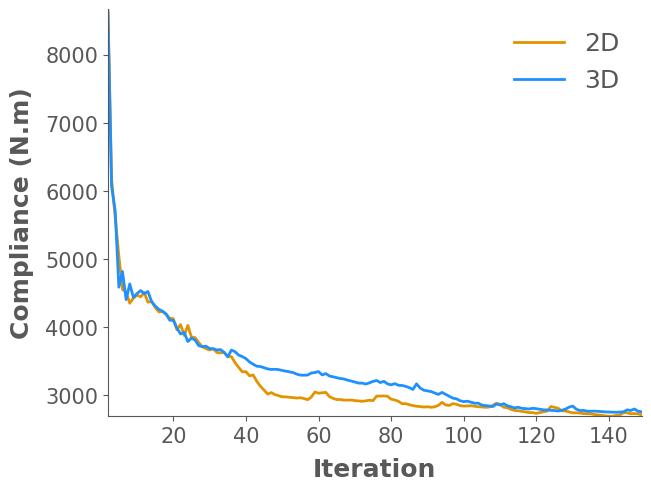

In [7]:
import matplotlib.pyplot as plt
import niceplots

plt.style.use(niceplots.get_style())

plt.plot(range(2,150), solver1.comp_hist[2:150], label='2D')
plt.plot(range(2,150), solver2.comp_hist[2:150], label='3D')
plt.ylabel('Compliance (N.m)')
plt.xlabel('Iteration')
plt.legend()